<a href="https://colab.research.google.com/github/malofeevakate/IMDB_reviews_classification/blob/main/IMDB_rewievs_LogClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score
from sklearn. model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# Загрузим данные train
train = pd.read_csv('imdb_train.csv')
y_train = pd.read_csv('y_imdb_train.csv')

In [ ]:
train.shape

(40000, 1)

In [ ]:
# число положительных и отрицательных отзывов примерно одинаково
y_train.value_counts()

sentiment
1            20045
0            19955
dtype: int64

## Попробуем создать облака слов для групп положительных и отрицательных отзывов

In [ ]:
# соединим трейн с таргетом
train['target'] = y_train

In [ ]:
train.head()

,review,target
0,I just came from seeing this movie and decided...,0
1,"It's hard for me to assign the ""fair"" number o...",1
2,This fake documentary is flawed on a lot of po...,0
3,This movie is absolutely terrible... Definatel...,0
4,"""Imagine if you could bring things back to lif...",1


In [ ]:
# уберем лишние пробелы в начале и конце отзыва
train.review = train.review.apply(lambda x : x.strip())
# уберем текст в тегах и сами знаки больше - меньше
train.review = train.review.apply(lambda x: re.sub(r'<.*>', '', x))
train.review = train.review.apply(lambda x: x.replace('<', '').replace('>', ''))
# вообще все небуквенные символы, то есть знаки препинания и тд
train.review = train.review.apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Все слова приведем к нижнему регистру
train.review = train.review.apply(lambda x: x.lower())

In [ ]:
# уберем стоп-слова
sw = stopwords.words('english')
train['review_without_sw'] = train.review.apply(lambda x: [word for word in x.split() if word not in (sw)])

In [ ]:
train.review_without_sw = train.review_without_sw.apply(lambda x : ' '.join(x))

In [ ]:
train.head()

,review,target,review_without_sw
0,i just came from seeing this movie and decided...,0,came seeing movie decided see others thought i...
1,its hard for me to assign the fair number of s...,1,hard assign fair number stars film settled 8 h...
2,this fake documentary is flawed on a lot of po...,0,fake documentary flawed lot points badly made ...
3,this movie is absolutely terrible definately a...,0,movie absolutely terrible definately bullt sto...
4,imagine if you could bring things back to life...,1,imagine could bring things back life one touch...


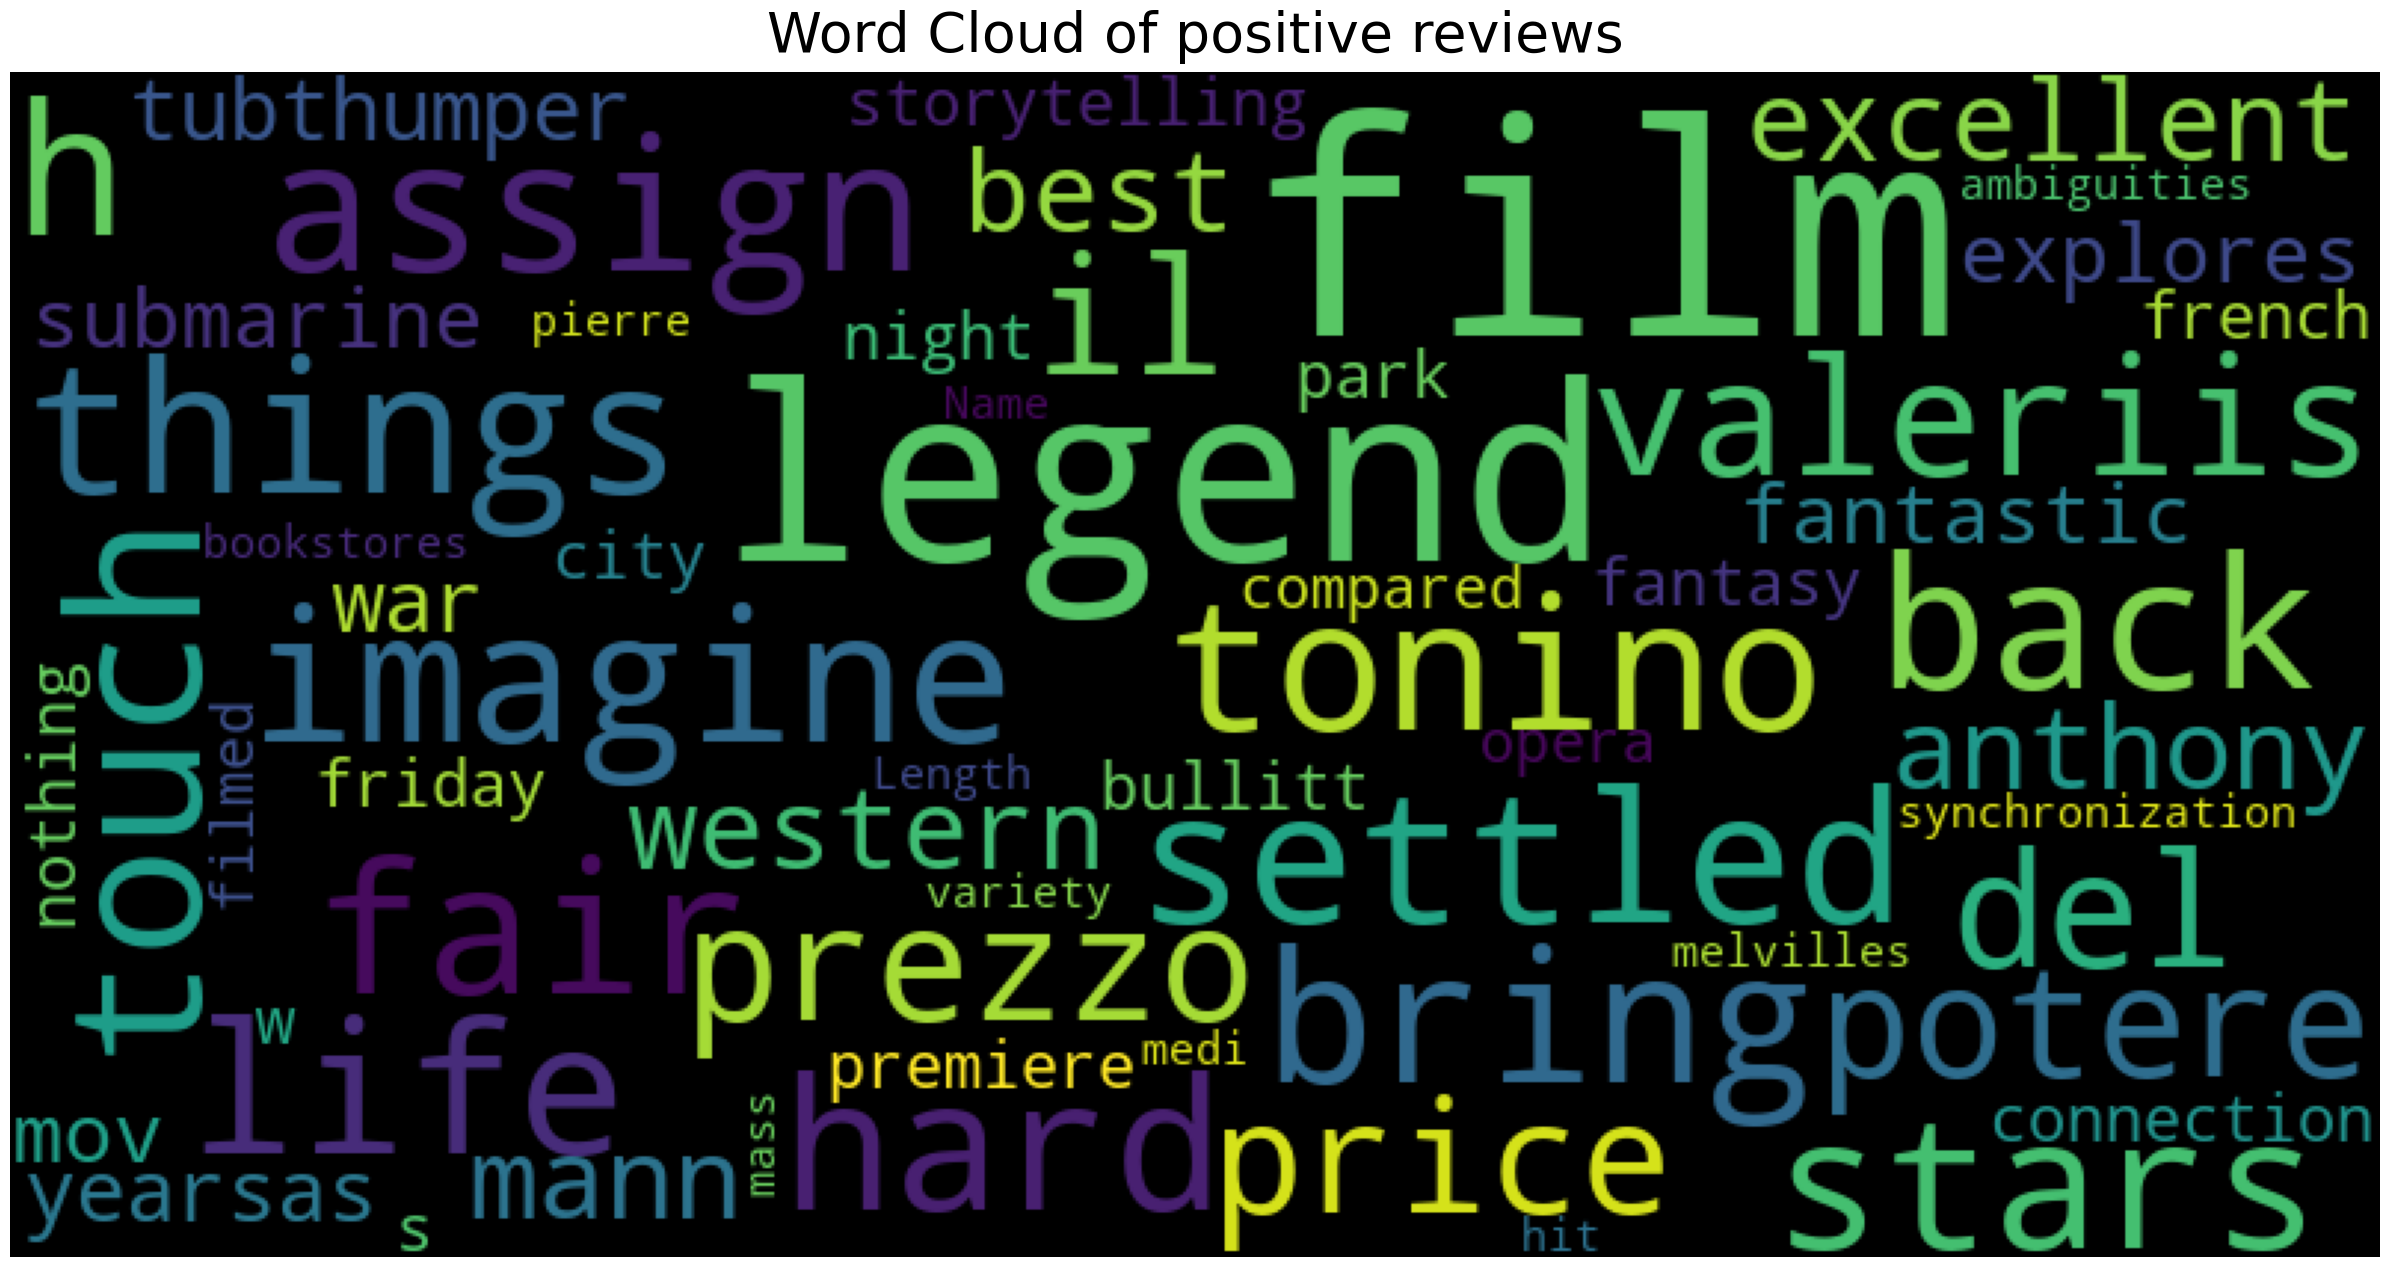

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'saw', 'makes', 'number', 'aka', 'dtype', 'object', 'review_without_sw'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(train.query('target == 1').review_without_sw, title="Word Cloud of positive reviews")

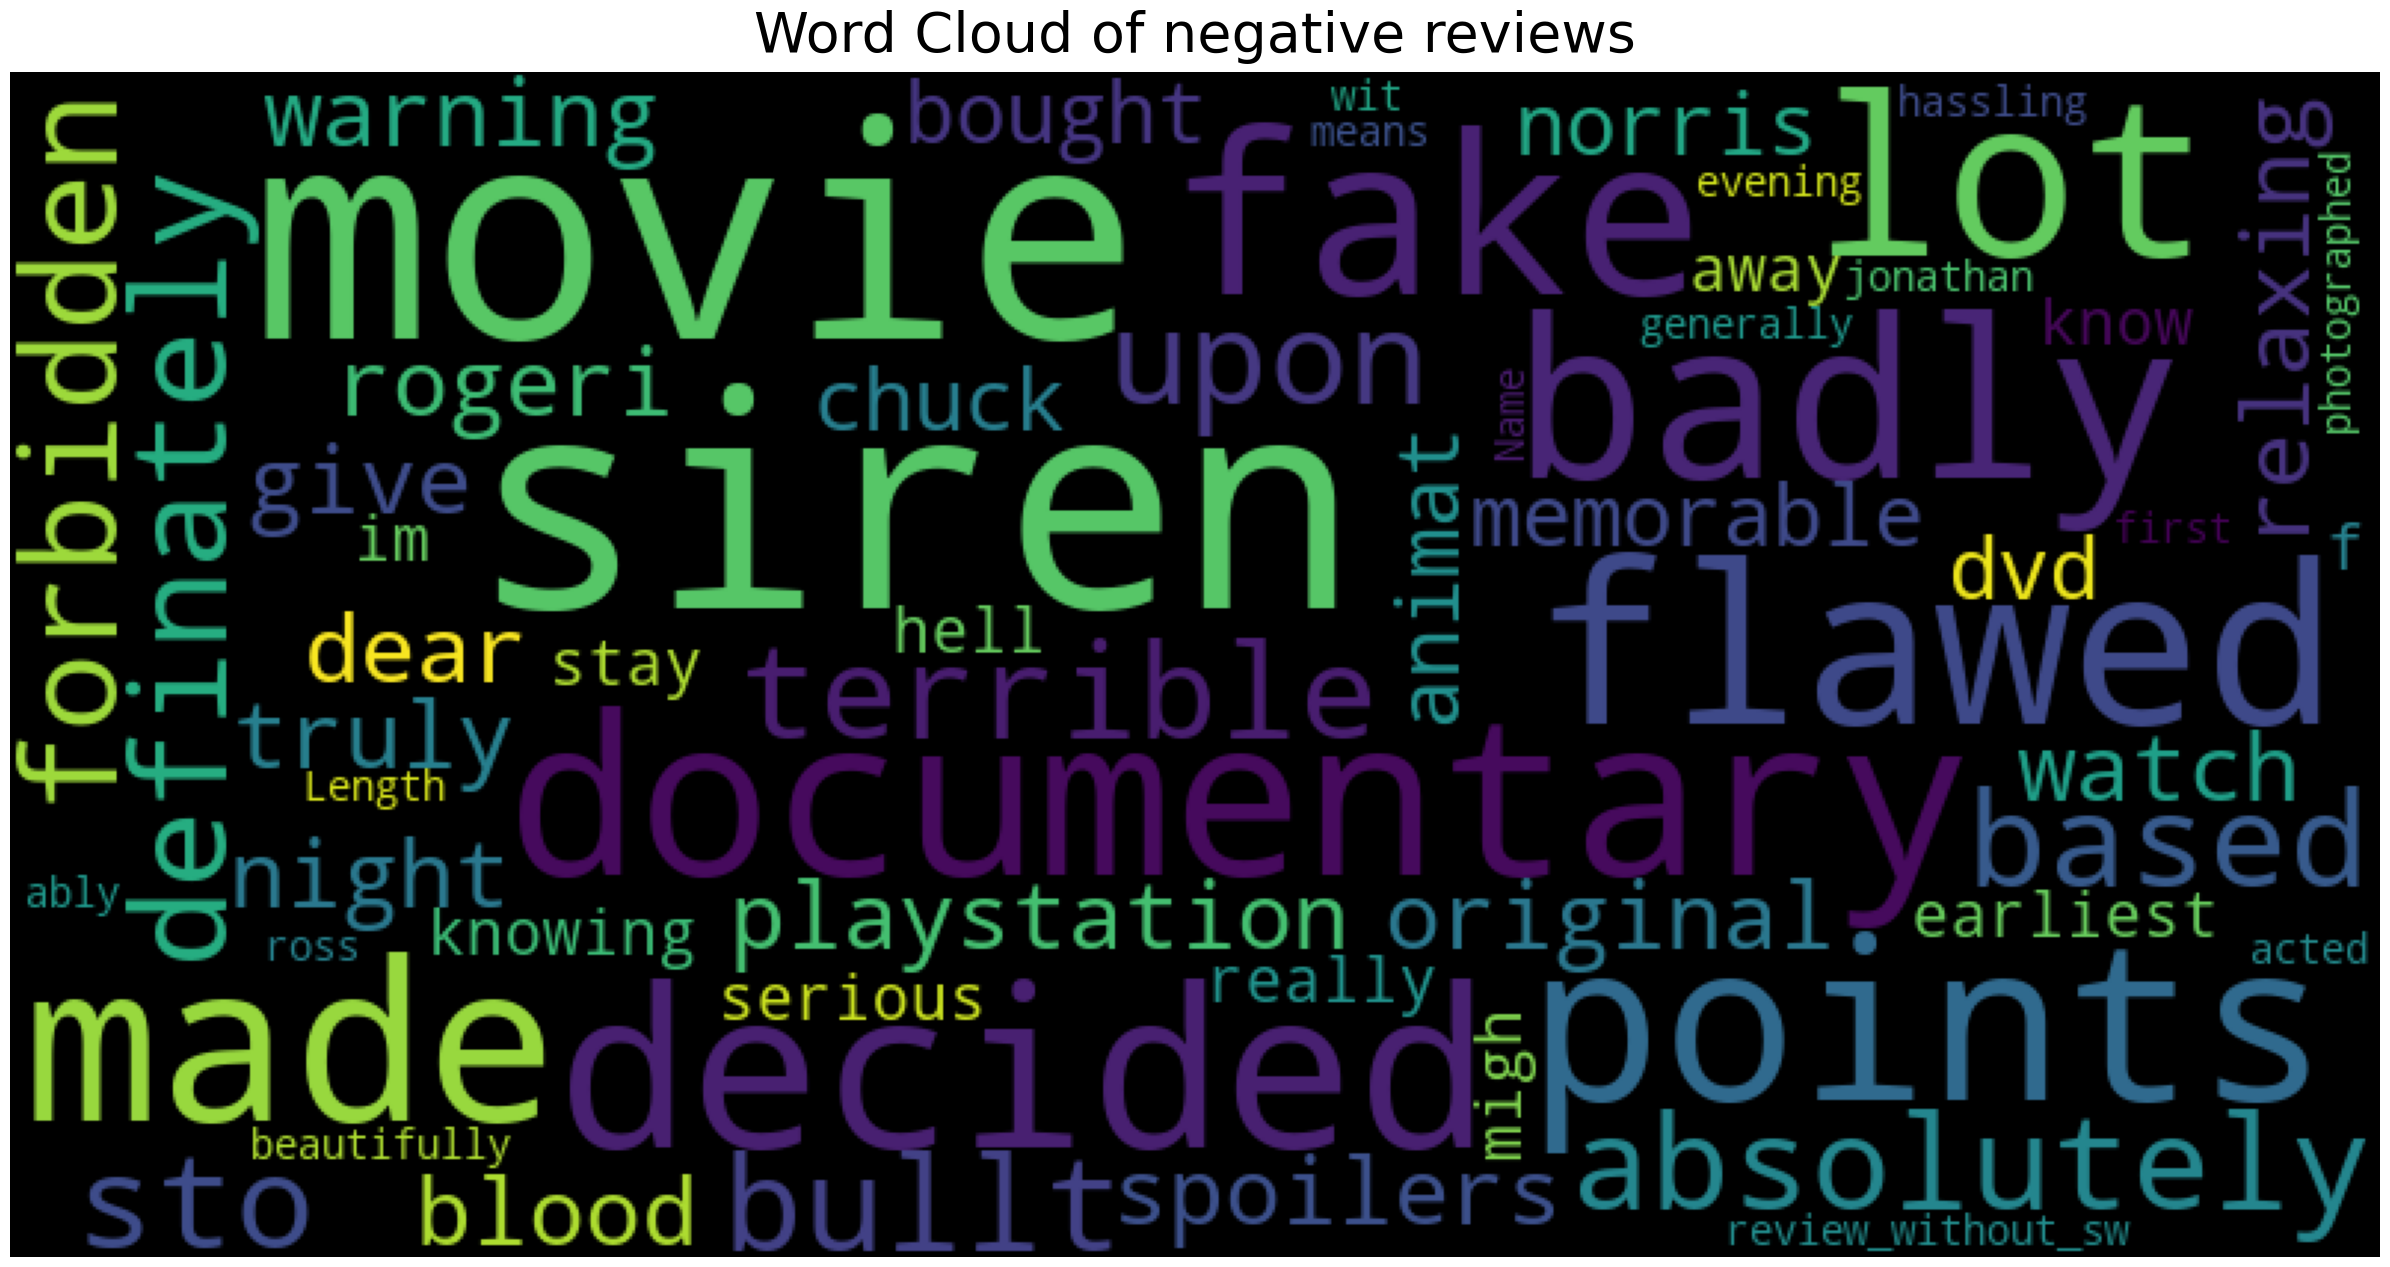

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'see', 'seeing', 'movies', 'came', 'others', 'thought', 'object', 'dtype'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(train.query('target == 0').review_without_sw, title="Word Cloud of negative reviews")

## Применим Vectorizer без предварительной обработки текста  
Есть несколько инструментов:  
- **CountVectorizer** (использовать не будем из-за плохой масштабируемости)  
- **HashingVectorizer** (использовать не будем, поскольку данных для него маловато)  
- **TfidfVectorizer** (метрика tf-idf учитывает то, как часто слово встречается в данном тексте и во всех остальных документах. Если слово встречается часто во всех документах, его вес практически нулевой, оно не важно, но если слово встречается только в определенных документах, то скорее всего они похожи. Посчитав меру tf-idf для всех слов одного и второго документа, можно получить их вектора, между которыми можно посчитать косинус угла, который и будет очень красиво от 0 до 1 показывать насколько два документа похожи, т.к. косинус равен скалярному произведению деленному на произведение длин). Им и воспользуемся.  

In [ ]:
# загрузим данные заново
train = pd.read_csv('imdb_train.csv')
y_train = pd.read_csv('y_imdb_train.csv')

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(train.review, y_train.sentiment, test_size = 0.3, random_state=42)

# Применение TF-IDF для извлечения признаков
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [ ]:
# Обучение модели
model = LogisticRegression(penalty = 'none')
model.fit(X_train_features, y_train)

LogisticRegression(penalty='none')

In [ ]:
# без регуляризации модель явно переобучается
print('ROC AUC: ',roc_auc_score(y_train,model.predict_proba(X_train_features)[:,1]))
print('accuracy: ',accuracy_score(y_train,model.predict(X_train_features)))

ROC AUC:  1.0
accuracy:  1.0


In [ ]:
print('ROC AUC: ',roc_auc_score(y_test,model.predict_proba(X_test_features)[:,1]))
print('accuracy: ',accuracy_score(y_test,model.predict(X_test_features)))

ROC AUC:  0.9439217622657942
accuracy:  0.8831666666666667


In [ ]:
fpr, tpr, thresh = roc_curve(y_test,model.predict_proba(X_test_features)[:,1])

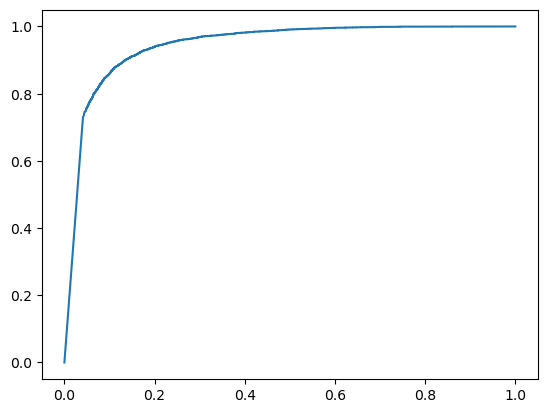

In [ ]:
# построим ROC-AUC кривую
plt.plot(fpr, tpr)

Таков результат применения Tf-idf и логита из коробки: модель сильно переобучается  
Попробуем поменять подход, все так же не применяя препроцессинг: поищем оптимальные показатели для разных регуляризаций, и лучшие сравним между собой на тесте, поскольку разные подходы регуляризации по-разному ее реализуют. Проверим, как каждая из регуляризаций борется с переобучением в данном случае

In [ ]:
# L1 регуляризация, ищем оптимальный штраф
model_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1')
model_l1.fit(X_train_features, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
parameters = {'C':np.arange(0.1, 10, 0.1)}
clf_l1 = GridSearchCV(model_l1, parameters)
result_l1 = clf_l1.fit(X_train_features, y_train)

In [ ]:
# результаты поиска лучшей модели классификатора без препроцессинга с регуляризатором L1
print(result_l1.best_params_)
print(result_l1.best_score_)
print(result_l1.best_estimator_)

{'C': 3.3000000000000003}
0.8826428571428572
LogisticRegression(C=3.3000000000000003, penalty='l1', solver='liblinear')


In [ ]:
best_model_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 3.3)
best_model_l1.fit(X_train_features, y_train)

LogisticRegression(C=3.3, penalty='l1', solver='liblinear')

In [ ]:
roc_auc_train_without_preprocessing_l1 = roc_auc_score(y_train,best_model_l1.predict_proba(X_train_features)[:,1])
print('ROC AUC: ',roc_auc_train_without_preprocessing_l1)
accuracy_train_without_preprocessing_l1 = accuracy_score(y_train,best_model_l1.predict(X_train_features))
print('accuracy: ',accuracy_train_without_preprocessing_l1)

ROC AUC:  0.9876827817884309
accuracy:  0.9460714285714286


In [ ]:
roc_auc_test_without_preprocessing_l1 =roc_auc_score(y_test,best_model_l1.predict_proba(X_test_features)[:,1])
print('ROC AUC: ',roc_auc_test_without_preprocessing_l1)
accuracy_test_without_preprocessing_l1 =accuracy_score(y_test,best_model_l1.predict(X_test_features))
print('accuracy: ',accuracy_test_without_preprocessing_l1)

ROC AUC:  0.9599174398004333
accuracy:  0.8981666666666667


In [ ]:
# посмотрим на работу L2 регуляризации на этой задаче
model_l2 = LogisticRegression()
model_l2.fit(X_train_features, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
clf_l2 = GridSearchCV(model_l2, parameters)
result_l2 = clf_ls.fit(X_train_features, y_train)

In [ ]:
print(result_l2.best_params_)
print(result_l2.best_score_)
print(result_l2.best_estimator_)

{'C': 5.7}
0.8938571428571429
LogisticRegression(C=5.7)


In [ ]:
best_model_l2 = LogisticRegression(C = 5.7)
best_model_l2.fit(X_train_features, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=5.7)

In [ ]:
roc_auc_train_without_preprocessing_l2 = roc_auc_score(y_train,best_model_l2.predict_proba(X_train_features)[:,1])
print('ROC AUC: ',roc_auc_train_without_preprocessing_l2)
accuracy_train_without_preprocessing_l2 = accuracy_score(y_train,best_model_l2.predict(X_train_features))
print('accuracy: ',accuracy_train_without_preprocessing_l2)

ROC AUC:  0.996029677757091
accuracy:  0.9748214285714286


In [ ]:
roc_auc_test_without_preprocessing_l2 =roc_auc_score(y_test,best_model_l2.predict_proba(X_test_features)[:,1])
print('ROC AUC: ',roc_auc_test_without_preprocessing_l2)
accuracy_test_without_preprocessing_l2 =accuracy_score(y_test,best_model_l2.predict(X_test_features))
print('accuracy: ',accuracy_test_without_preprocessing_l2)

ROC AUC:  0.9654164435638394
accuracy:  0.9041666666666667


## Попробуем предварительно преобразовать текст отзывов  
Будет ли эффект, если векторайзер натравить на предварительно обработанный текст?

In [ ]:
# Загрузим данные train / test
train = pd.read_csv('imdb_train.csv')
test = pd.read_csv('imdb_test.csv')
y_train = pd.read_csv('y_imdb_train.csv')
X = pd.concat([train, test])

In [ ]:
train.shape

(40000, 1)

In [ ]:
test.shape

(10000, 2)

***Проведем преобразования текста отзывов***

In [ ]:
# уберем лишние пробелы в начале и конце отзыва
X.review = X.review.apply(lambda x : x.strip())
# уберем текст в тегах и сами знаки больше - меньше
X.review = X.review.apply(lambda x: re.sub(r'<.*?>', ' ', x))
X.review = X.review.apply(lambda x: x.replace('<', ' ').replace('>', ' '))
# вообще все небуквенные символы, то есть знаки препинания и тд
X.review = X.review.apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Все слова приведем к нижнему регистру
X.review = X.review.apply(lambda x: x.lower())

***Уберем и в тесте, и в контроле стоп-слова***  

In [ ]:
%%time
sw = stopwords.words('english')
X['review_without_sw'] = X.review.apply(lambda x: [word for word in x.split() if word not in (sw)])

CPU times: total: 18.6 s
Wall time: 18.6 s


***Схлопнем однокоренные слова в одно, используя лемматизацию и стемминг***   
 Лемматизация является более мощной операцией и учитывает морфологический анализ слов. Если Стемминг – общая операция, то лемматизация – интеллектуальная операция, в которой будет возвращена правильная форма слова как в словаре.

In [ ]:
%%time
porter_stemmer  = PorterStemmer()
X['review_ps'] = X.review_without_sw.apply(lambda x: [porter_stemmer.stem(y) for y in x])

CPU times: total: 1min 55s
Wall time: 1min 55s


In [ ]:
%%time
lancaster_stemmer = LancasterStemmer()
X['review_ls'] = X.review_without_sw.apply(lambda x: [lancaster_stemmer.stem(y) for y in x])

CPU times: total: 1min 25s
Wall time: 1min 25s


In [ ]:
%%time
lemmatizer = WordNetLemmatizer()
X['review_lemmatizer'] = X.review_without_sw.apply(lambda x: [lemmatizer.lemmatize(y)for y in x])

CPU times: total: 25 s
Wall time: 25.1 s


In [ ]:
X.head()

,review,id,review_without_sw,review_ps,review_ls,review_lemmatizer
0,i just came from seeing this movie and decided...,NaN,"[came, seeing, movie, decided, see, others, th...","[came, see, movi, decid, see, other, thought, ...","[cam, see, movy, decid, see, oth, thought, im,...","[came, seeing, movie, decided, see, others, th..."
1,its hard for me to assign the fair number of s...,NaN,"[hard, assign, fair, number, stars, film, sett...","[hard, assign, fair, number, star, film, settl...","[hard, assign, fair, numb, star, film, settl, ...","[hard, assign, fair, number, star, film, settl..."
2,this fake documentary is flawed on a lot of po...,NaN,"[fake, documentary, flawed, lot, points, badly...","[fake, documentari, flaw, lot, point, badli, m...","[fak, docu, flaw, lot, point, bad, mad, uninte...","[fake, documentary, flawed, lot, point, badly,..."
3,this movie is absolutely terrible definately a...,NaN,"[movie, absolutely, terrible, definately, bull...","[movi, absolut, terribl, defin, bullt, stori, ...","[movy, absolv, terr, defin, bullt, story, ev, ...","[movie, absolutely, terrible, definately, bull..."
4,imagine if you could bring things back to life...,NaN,"[imagine, could, bring, things, back, life, on...","[imagin, could, bring, thing, back, life, one,...","[imagin, could, bring, thing, back, lif, on, t...","[imagine, could, bring, thing, back, life, one..."


In [ ]:
for c in X.columns[2:]:
    X[c] = X[c].apply(lambda x: ' '.join(x))

In [ ]:
# разделим выборки на тест и трейн
train_df = X[:40000]
test_df = X[40000:]

In [ ]:
y_train.head()

,sentiment
0,0
1,1
2,0
3,0
4,1


## Сравним результаты работы логита в зависимости от подхода к препроцессингу отзывов

**PORTER_STEMMER**

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train_ps, X_test_ps, y_train_ps, y_test_ps = train_test_split(train_df.review_ps, y_train.sentiment, test_size = 0.3, random_state=42)

# Применение TF-IDF для извлечения признаков
vectorizer_ps = TfidfVectorizer()
X_train_features_ps = vectorizer_ps.fit_transform(X_train_ps)
X_test_features_ps = vectorizer_ps.transform(X_test_ps)

In [ ]:
# Обучение модели L1
model_ps_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1')
model_ps_l1.fit(X_train_features_ps, y_train_ps)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
clf_ps_l1 = GridSearchCV(model_ps_l1, parameters)
result_ps_l1 = clf_ps_l1.fit(X_train_features_ps, y_train_ps)

In [ ]:
# результаты поиска лучшей модели классификатора без препроцессинга с регуляризатором L2
print(result_ps_l1.best_params_)
print(result_ps_l1.best_score_)
print(result_ps_l1.best_estimator_)

{'C': 2.0}
0.8811785714285716
LogisticRegression(C=2.0, penalty='l1', solver='liblinear')


In [ ]:
best_model_ps_l1 = LogisticRegression(solver = 'liblinear', C = 2)
best_model_ps_l1.fit(X_train_features_ps, y_train_ps)

LogisticRegression(C=2, solver='liblinear')

In [ ]:
roc_auc_train_ps_l1 = roc_auc_score(y_train_ps,best_model_ps_l1.predict_proba(X_train_features_ps)[:,1])
print('ROC AUC: ',roc_auc_train_ps_l1)
accuracy_train_ps_l1 = accuracy_score(y_train_ps,best_model_ps_l1.predict(X_train_features_ps))
print('accuracy: ',accuracy_train_ps_l1)

ROC AUC:  0.987255060030542
accuracy:  0.9458928571428571


In [ ]:
roc_auc_test_ps_l1 = roc_auc_score(y_test_ps,best_model_ps_l1.predict_proba(X_test_features_ps)[:,1])
print('ROC AUC: ',roc_auc_test_ps_l1)
accuracy_test_ps_l1 = accuracy_score(y_test_ps,best_model_ps_l1.predict(X_test_features_ps))
print('accuracy: ',accuracy_test_ps_l1)

ROC AUC:  0.9615352530246493
accuracy:  0.89725


In [ ]:
# Обучение модели L2
model_ps_l2 = LogisticRegression()
model_ps_l2.fit(X_train_features_ps, y_train_ps)

LogisticRegression()

In [ ]:
clf_ps_l2 = GridSearchCV(model_ps_l2, parameters)
result_ps_l2 = clf_ps_l2.fit(X_train_features_ps, y_train_ps)

In [ ]:
print(result_ps_l2.best_params_)
print(result_ps_l2.best_score_)
print(result_ps_l2.best_estimator_)

{'C': 3.9000000000000004}
0.8904285714285715
LogisticRegression(C=3.9000000000000004)


In [ ]:
best_model_ps_l2 = LogisticRegression(C = 3.9)
best_model_ps_l2.fit(X_train_features_ps, y_train_ps)

LogisticRegression(C=3.9)

In [ ]:
roc_auc_train_ps_l2 = roc_auc_score(y_train_ps,best_model_ps_l2.predict_proba(X_train_features_ps)[:,1])
print('ROC AUC: ',roc_auc_train_ps_l2)
accuracy_train_ps_l2 = accuracy_score(y_train_ps,best_model_ps_l2.predict(X_train_features_ps))
print('accuracy: ',accuracy_train_ps_l2)

ROC AUC:  0.9931435839950529
accuracy:  0.9620357142857143


In [ ]:
roc_auc_test_ps_l2 = roc_auc_score(y_test_ps,best_model_ps_l2.predict_proba(X_test_features_ps)[:,1])
print('ROC AUC: ',roc_auc_test_ps_l2)
accuracy_test_ps_l2 = accuracy_score(y_test_ps,best_model_ps_l2.predict(X_test_features_ps))
print('accuracy: ',accuracy_test_ps_l2)

ROC AUC:  0.9620013903559853
accuracy:  0.8984166666666666


**LANCASTER_STEMMER**

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(train_df.review_ls, y_train.sentiment, test_size = 0.3, random_state=42)

# Применение TF-IDF для извлечения признаков
vectorizer_ls = TfidfVectorizer()
X_train_features_ls = vectorizer_ls.fit_transform(X_train_ls)
X_test_features_ls = vectorizer_ls.transform(X_test_ls)

In [ ]:
# Обучение модели L1
model_ls_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1')
model_ls_l1.fit(X_train_features_ls, y_train_ls)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
clf_ls_l1 = GridSearchCV(model_ls_l1, parameters)
result_ls_l1 = clf_ls_l1.fit(X_train_features_ls, y_train_ls)

In [ ]:
print(result_ls_l1.best_params_)
print(result_ls_l1.best_score_)
print(result_ls_l1.best_estimator_)

{'C': 2.5000000000000004}
0.8778214285714284
LogisticRegression(C=2.5000000000000004, penalty='l1', solver='liblinear')


In [ ]:
best_model_ls_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 2.5)
best_model_ls_l1.fit(X_train_features_ls, y_train_ls)

LogisticRegression(C=2.5, penalty='l1', solver='liblinear')

In [ ]:
roc_auc_train_ls_l1 = roc_auc_score(y_train_ls,best_model_ls_l1.predict_proba(X_train_features_ls)[:,1])
print('ROC AUC: ',roc_auc_train_ls_l1)
accuracy_train_ls_l1 = accuracy_score(y_train_ls,best_model_ls_l1.predict(X_train_features_ls))
print('accuracy: ',accuracy_train_ls_l1)

ROC AUC:  0.9797469436236904
accuracy:  0.92875


In [ ]:
roc_auc_test_ls_l1 = roc_auc_score(y_test_ls,best_model_ls_l1.predict_proba(X_test_features_ls)[:,1])
print('ROC AUC: ',roc_auc_test_ls_l1)
accuracy_test_ls_l1 = accuracy_score(y_test_ls,best_model_ls_l1.predict(X_test_features_ls))
print('accuracy: ',accuracy_test_ls_l1)

ROC AUC:  0.9554990245979116
accuracy:  0.8865833333333333


In [ ]:
# Обучение модели L2
model_ls_l2 = LogisticRegression()
model_ls_l2.fit(X_train_features_ls, y_train_ls)

LogisticRegression()

In [ ]:
clf_ls_l2 = GridSearchCV(model_ls_l2, parameters)
result_ls_l2 = clf_ls_l2.fit(X_train_features_ls, y_train_ls)

In [ ]:
print(result_ls_l2.best_params_)
print(result_ls_l2.best_score_)
print(result_ls_l2.best_estimator_)

{'C': 2.9000000000000004}
0.8860357142857141
LogisticRegression(C=2.9000000000000004)


In [ ]:
best_model_ls_l2 = LogisticRegression(C = 2.9)
best_model_ls_l2.fit(X_train_features_ls, y_train_ls)

LogisticRegression(C=2.9)

In [ ]:
roc_auc_train_ls_l2 = roc_auc_score(y_train_ls,best_model_ls_l2.predict_proba(X_train_features_ls)[:,1])
print('ROC AUC: ',roc_auc_train_ls_l2)
accuracy_train_ls_l2 = accuracy_score(y_train_ls,best_model_ls_l2.predict(X_train_features_ls))
print('accuracy: ',accuracy_train_ls_l2)

ROC AUC:  0.9885013054110909
accuracy:  0.9496785714285715


In [ ]:
roc_auc_test_ls_l2 = roc_auc_score(y_test_ls,best_model_ls_l2.predict_proba(X_test_features_ls)[:,1])
print('ROC AUC: ',roc_auc_test_ls_l2)
accuracy_test_ls_l2 = accuracy_score(y_test_ls,best_model_ls_l2.predict(X_test_features_ls))
print('accuracy: ',accuracy_test_ls_l2)

ROC AUC:  0.9594734148240283
accuracy:  0.89275


**LEMMATIZER**

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(train_df.review_lemmatizer, y_train.sentiment, test_size = 0.3, random_state=42)

# Применение TF-IDF для извлечения признаков
vectorizer_lm = TfidfVectorizer()
X_train_features_lm = vectorizer_lm.fit_transform(X_train_lm)
X_test_features_lm = vectorizer_lm.transform(X_test_lm)

In [ ]:
# Обучение модели L1
model_lm_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1')
model_lm_l1.fit(X_train_features_lm, y_train_lm)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
clf_lm_l1 = GridSearchCV(model_lm_l1, parameters)
result_lm_l1 = clf_lm_l1.fit(X_train_features_lm, y_train_lm)

In [ ]:
print(result_lm_l1.best_params_)
print(result_lm_l1.best_score_)
print(result_lm_l1.best_estimator_)

{'C': 3.2}
0.8834642857142857
LogisticRegression(C=3.2, penalty='l1', solver='liblinear')


In [ ]:
best_model_lm_l1 = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 3.2)
best_model_lm_l1.fit(X_train_features_lm, y_train_lm)

LogisticRegression(C=3.2, penalty='l1', solver='liblinear')

In [ ]:
roc_auc_train_lm_l1 = roc_auc_score(y_train_lm,best_model_lm_l1.predict_proba(X_train_features_lm)[:,1])
print('ROC AUC: ',roc_auc_train_lm_l1)
accuracy_train_lm_l1 = accuracy_score(y_train_lm,best_model_lm_l1.predict(X_train_features_lm))
print('accuracy: ',accuracy_train_lm_l1)

ROC AUC:  0.988280740173446
accuracy:  0.9467142857142857


In [ ]:
roc_auc_test_lm_l1 = roc_auc_score(y_test_lm,best_model_lm_l1.predict_proba(X_test_features_lm)[:,1])
print('ROC AUC: ',roc_auc_test_lm_l1)
accuracy_test_lm_l1 = accuracy_score(y_test_lm,best_model_lm_l1.predict(X_test_features_lm))
print('accuracy: ',accuracy_test_lm_l1)

ROC AUC:  0.9586660916343211
accuracy:  0.89225


In [ ]:
# Обучение модели L1=2
model_lm_l2 = LogisticRegression()
model_lm_l2.fit(X_train_features_lm, y_train_lm)

LogisticRegression()

In [ ]:
clf_lm_l2 = GridSearchCV(model_lm_l2, parameters)
result_lm_l2 = clf_lm_l2.fit(X_train_features_lm, y_train_lm)

In [ ]:
print(result_lm_l2.best_params_)
print(result_lm_l2.best_score_)
print(result_lm_l2.best_estimator_)

{'C': 6.1}
0.8911428571428572
LogisticRegression(C=6.1)


In [ ]:
best_model_lm_l2 = LogisticRegression(C = 6.1)
best_model_lm_l2.fit(X_train_features_lm, y_train_lm)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=6.1)

In [ ]:
roc_auc_train_lm_l2 = roc_auc_score(y_train_lm,best_model_lm_l2.predict_proba(X_train_features_lm)[:,1])
print('ROC AUC: ',roc_auc_train_lm_l2)
accuracy_train_lm_l2 = accuracy_score(y_train_lm,best_model_lm_l2.predict(X_train_features_lm))
print('accuracy: ',accuracy_train_lm_l2)

ROC AUC:  0.997455114216455
accuracy:  0.9805


In [ ]:
roc_auc_test_lm_l2 = roc_auc_score(y_test_lm,best_model_lm_l2.predict_proba(X_test_features_lm)[:,1])
print('ROC AUC: ',roc_auc_test_lm_l2)
accuracy_test_lm_l2 = accuracy_score(y_test_lm,best_model_lm_l2.predict(X_test_features_lm))
print('accuracy: ',accuracy_test_lm_l2)

ROC AUC:  0.9638729678544418
accuracy:  0.9013333333333333


Сравним метрики полученных моделей

In [ ]:
print('metrics for train and test of different models')
pd.DataFrame({'metrics' : ['ROC-AUC_l1_reg', 'accuracy_l1_reg', 'ROC-AUC_l2_reg', 'accuracy_l2_reg'],
'without_preprosessing_train': [roc_auc_train_without_preprocessing_l1, accuracy_train_without_preprocessing_l1, roc_auc_train_without_preprocessing_l2, accuracy_train_without_preprocessing_l2],
'without_preprosessing_test': [roc_auc_test_without_preprocessing_l1, accuracy_test_without_preprocessing_l1, roc_auc_test_without_preprocessing_l2, accuracy_test_without_preprocessing_l2],
'porter_stemmer_train': [roc_auc_train_ps_l1, accuracy_train_ps_l1, roc_auc_train_ps_l2, accuracy_train_ps_l2],
'porter_stemmer_test': [roc_auc_test_ps_l1, accuracy_test_ps_l1, roc_auc_test_ps_l2, accuracy_test_ps_l2],
'lancaster_stemmer_train': [roc_auc_train_ls_l1, accuracy_train_ls_l1, roc_auc_train_ls_l2, accuracy_train_ls_l2],
'lancaster_stemmer_test': [roc_auc_test_ls_l1, accuracy_test_ls_l1, roc_auc_test_ls_l2, accuracy_test_ls_l2],
'lemmatizer_train': [roc_auc_train_lm_l1, accuracy_train_lm_l1, roc_auc_train_lm_l2, accuracy_train_lm_l2],
'lemmatizer_test': [roc_auc_test_lm_l1, accuracy_test_lm_l1, roc_auc_test_lm_l2, accuracy_test_lm_l2]})

metrics for train and test of different models


,metrics,without_preprosessing_train,without_preprosessing_test,porter_stemmer_train,porter_stemmer_test,lancaster_stemmer_train,lancaster_stemmer_test,lemmatizer_train,lemmatizer_test
0,ROC-AUC_l1_reg,0.987683,0.959917,0.987255,0.961535,0.979747,0.955499,0.988281,0.958666
1,accuracy_l1_reg,0.946071,0.898167,0.945893,0.897250,0.928750,0.886583,0.946714,0.892250
2,ROC-AUC_l2_reg,0.996030,0.965416,0.993144,0.962001,0.988501,0.959473,0.997455,0.963873
3,accuracy_l2_reg,0.974821,0.904167,0.962036,0.898417,0.949679,0.892750,0.980500,0.901333


Видно, что наилучшие результаты показывает L2 - регуляризация во всех вариантах препроцессинга.  
Получим тест предикт по всем моделям и посмотрим, где accuracy на тесте будет больше 0,875

In [ ]:
# ответы для модели без препроцессинга
test_review = vectorizer.transform(test_df.review_without_sw)
my_answer = pd.DataFrame(best_model_l2.predict(test_review))
my_answer.columns = ['prediction']
my_answer['id'] = test['id']
my_answer = my_answer[['id', 'prediction']]
my_answer.to_csv('prediction.csv', index = False)

In [ ]:
# ответы для модели porter_stemmer
test_review_ps = vectorizer_ps.transform(test_df.review_ps)
my_answer_ps = pd.DataFrame(model_ps_l2.predict(test_review_ps))
my_answer_ps.columns = ['prediction']
my_answer_ps['id'] = test['id']
my_answer_ps = my_answer[['id', 'prediction']]
my_answer_ps.to_csv('prediction_ps.csv', index = False)

In [ ]:
# ответы для модели lancaster_stemmer
test_review_ls = vectorizer_ls.transform(test_df.review_ls)
my_answer_ls = pd.DataFrame(model_ls_l2.predict(test_review_ls))
my_answer_ls.columns = ['prediction']
my_answer_ls['id'] = test['id']
my_answer_ls = my_answer[['id', 'prediction']]
my_answer_ls.to_csv('prediction_ls.csv', index = False)

In [ ]:
# ответы для модели lemmatizer
test_review_lm = vectorizer_lm.transform(test_df.review_lemmatizer)
my_answer_lm = pd.DataFrame(model_lm_l2.predict(test_review_lm))
my_answer_lm.columns = ['prediction']
my_answer_lm['id'] = test['id']
my_answer_lm = my_answer[['id', 'prediction']]
my_answer_lm.to_csv('prediction_lm.csv', index = False)

Все модели показали метрику accuracy больше порогового значения, при этом лемматизация оказалась самым быстрым подходом препроцессинга